
# Cropped Decoding on BCIC IV 2a Dataset
   :depth: 2


Building on the [Trialwise decoding](./plot_bcic_iv_2a_moabb_trial.html)_,
we now do more data-efficient cropped decoding!

In Braindecode, there are two supported configurations created for
training models: trialwise decoding and cropped decoding. We will
explain this visually by comparing trialwise to cropped decoding.

<img src="https://braindecode.org/stable/_static/trialwise_explanation.png" alt="Trialwise decoding">
<img src="https://braindecode.org/stable/_static/cropped_explanation.png" alt="Cropped decoding">
On the left, you see trialwise decoding:

1. A complete trial is pushed through the network.
2. The network produces a prediction.
3. The prediction is compared to the target (label) for that trial to
   compute the loss.

On the right, you see cropped decoding:

1. Instead of a complete trial, crops are pushed through the network.
2. For computational efficiency, multiple neighbouring crops are pushed
   through the network simultaneously (these neighbouring crops are
   called compute windows)
3. Therefore, the network produces multiple predictions (one per crop in
   the window)
4. The individual crop predictions are *AVERAGED* before computing the
   loss function

This averaging of predictions of small sub-windows is the key difference
between trialwise and cropped decoding. It was introduced in [1]_ and it impact
on the parameters of the network.

It is important to note that the averaging of predictions is only done
during training. During testing, the network is still applied to crops
and the predictions are averaged afterwards.


<div class="alert alert-info"><h4>Note</h4><p>-  The network architecture implicitly defines the crop size (it is the
       receptive field size, i.e., the number of timesteps the network uses
       to make a single prediction)
    -  The window size is a user-defined hyperparameter, called
       ``input_window_samples`` in Braindecode. It mostly affects runtime
       (larger window sizes should be faster). As a rule of thumb, you can
       set it to two times the crop size.
    -  Crop size and window size together define how many predictions the
       network makes per window: ``#window − #crop + 1 = #predictions``</p></div>

<div class="alert alert-info"><h4>Note</h4><p>For cropped decoding, the above training setup is mathematically
    similar to sampling crops in your dataset, pushing them through the
    network and training directly on the individual crops. However, the
    if their position would be randomly selected, the crops would be less
    correlated in contrast to the neighbourhood crops selected from a window.
    At the same time, the above training setup is much faster as it avoids
    redundant computations by using dilated convolutions, see [2]_.
    However, the two setups are only mathematically related in case (1)
    your network does not use any padding or only left padding and
    (2) your loss function leads
    to the same gradients when using the averaged output. The first is true
    for our shallow and deep ConvNet models and the second is true for the
    log-softmax outputs and negative log likelihood loss that is typically
    used for classification in PyTorch.</p></div>



## Loading and preprocessing the dataset

Loading and preprocessing stays the same as in the [Trialwise decoding
tutorial](./plot_bcic_iv_2a_moabb_trial.html)_.



In [1]:
from braindecode.datasets import MOABBDataset

subject_id = 3
dataset = MOABBDataset(dataset_name="BNCI2014_001", subject_ids=[subject_id])

from numpy import multiply

from braindecode.preprocessing import (
    Preprocessor,
    exponential_moving_standardize,
    preprocess,
)

low_cut_hz = 4.  # low cut frequency for filtering
high_cut_hz = 38.  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000
# Factor to convert from V to uV
factor = 1e6

preprocessors = [
    Preprocessor('pick_types', eeg=True, meg=False, stim=False),
    # Keep EEG sensors
    Preprocessor(lambda data: multiply(data, factor)),  # Convert from V to uV
    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),
    # Bandpass filter
    Preprocessor(exponential_moving_standardize,
                 # Exponential moving standardization
                 factor_new=factor_new, init_block_size=init_block_size)
]

# Transform the data
preprocess(dataset, preprocessors, n_jobs=-1)

e:\schirri_test_braindecode\.venv\lib\site-packages\braindecode\preprocessing\preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


## Create model and compute windowing parameters
In contrast to trialwise decoding, we first have to create the model
before we can cut the dataset into windows. This is because we need to
know the neural network parameters to know how large the sub-window
stride should be.

We first choose the compute/input window size that will be fed to the
network during training. This has to be larger than the networks
the number of timesteps size and can otherwise be chosen for computational
efficiency (see explanations in the beginning of this tutorial). Here we
choose 1000 samples, which are 4 seconds for the 250 Hz sampling rate.




In [2]:
input_window_samples = 1000

Now we create the model. To enable it to be used in cropped decoding
efficiently, we manually set the length of the final convolution layer
to some length that makes the number of timesteps of the ConvNet smaller
than ``input_window_samples`` (see ``final_conv_length=30`` in the model
definition).




In [3]:
import torch

from braindecode.models import ShallowFBCSPNet
from braindecode.util import set_random_seeds

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to roughly reproduce results
# Note that with cudnn benchmark set to True, GPU indeterminism
# may still make results substantially different between runs.
# To obtain more consistent results at the cost of increased computation time,
# you can set `cudnn_benchmark=False` in `set_random_seeds`
# or remove `torch.backends.cudnn.benchmark = True`
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
classes = list(range(n_classes))
# Extract number of chans from dataset
n_chans = dataset[0][0].shape[0]

model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length=30,
)

# Display torchinfo table describing the model
print(model)

# Send model to GPU
if cuda:
    _ = model.cuda()

e:\schirri_test_braindecode\.venv\lib\site-packages\braindecode\util.py:51: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(
e:\schirri_test_braindecode\.venv\lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
e:\schirri_test_braindecode\.venv\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)        [1, 22, 1000]             [1, 4, 32]                --                        --
├─Ensure4d (ensuredims): 1-1             [1, 22, 1000]             [1, 22, 1000, 1]          --                        --
├─Rearrange (dimshuffle): 1-2            [1, 22, 1000, 1]          [1, 1, 1000, 22]          --                        --
├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1000, 22]          [1, 40, 976, 1]           36,240                    --
├─BatchNorm2d (bnorm): 1-4               [1, 40, 976, 1]           [1, 40, 976, 1]           80                        --
├─Expression (conv_nonlin_exp): 1-5      [1, 40, 976, 1]           [1, 40, 976, 1]           --                        --
├─AvgPool2d (pool): 1-6                  [1, 40, 976, 1]           [1, 40, 61, 1]            --                        [75, 1]
├─Express

And now we transform model with strides to a model that outputs dense
prediction, so we can use it to obtain predictions for all
crops.




In [4]:
model.to_dense_prediction_model()

To know the models’ output shape without the last layer, we calculate the
shape of model output for a dummy input.




In [5]:
n_preds_per_input = model.get_output_shape()[2]

## Cut the data into windows
In contrast to trialwise decoding, we have to supply an explicit
window size and window stride to the ``create_windows_from_events``
function.




In [6]:
from braindecode.preprocessing import create_windows_from_events

trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])

# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    window_size_samples=input_window_samples,
    window_stride_samples=n_preds_per_input,
    drop_last_window=False,
    preload=True
)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']


## Split the dataset

This code is the same as in trialwise decoding.




In [7]:
splitted = windows_dataset.split('session')
train_set = splitted['0train']  # Session train
valid_set = splitted['1test']  # Session evaluation

## Training
In difference to trialwise decoding, we now should supply
``cropped=True`` to the EEGClassifier, and ``CroppedLoss`` as the
criterion, as well as ``criterion__loss_function`` as the loss function
applied to the meaned predictions.

<div class="alert alert-info"><h4>Note</h4><p>In this tutorial, we use some default parameters that we
    have found to work well for motor decoding, however we strongly
    encourage you to perform your own hyperparameter optimization using
    cross validation on your training data.</p></div>




In [8]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier
from braindecode.training import CroppedLoss

# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 200

clf = EEGClassifier(
    model,
    cropped=True,
    criterion=CroppedLoss,
    criterion__loss_function=torch.nn.functional.nll_loss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    iterator_train__shuffle=True,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
    classes=classes,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
_ = clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  ----------------  ------------  ------  ------
      1            0.2500        1.4641            0.2500        4.9696  0.0006  0.7150
      2            0.4132        1.2296            0.3715        3.3171  0.0006  0.2030
      3            0.4722        1.0986            0.4653        1.9979  0.0006  0.2030
      4            0.6146        0.9834            0.5938        1.0793  0.0006  0.2130
      5            0.7083        0.8880            0.6979        0.8981  0.0006  0.2040
      6            0.7882        0.8094            0.7431        0.8260  0.0006  0.2030
      7            0.7431        0.7436            0.7014        0.8193  0.0006  0.2030
      8            0.8090        0.6596            0.8125        0.6996  0.0006  0.2020
      9            0.8264        0.6073            0.7396        0.7822  0.0006  0.2034
     10            0.9306       

## Plot Results
<div class="alert alert-info"><h4>Note</h4><p>Note that we drop further in the classification error and
    loss as in the trialwise decoding tutorial.</p></div>




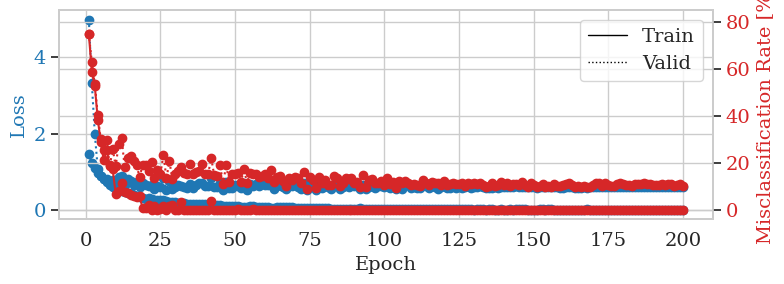

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_accuracy',
                   'valid_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_accuracy,
               valid_misclass=100 - 100 * df.valid_accuracy)

fig, ax1 = plt.subplots(figsize=(8, 3))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False,
    fontsize=14)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(
    Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(
    Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()

## Plot Confusion Matrix

Generate a confusion matrix as in [2]_




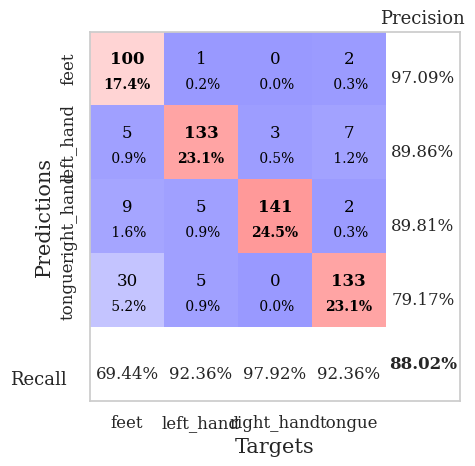

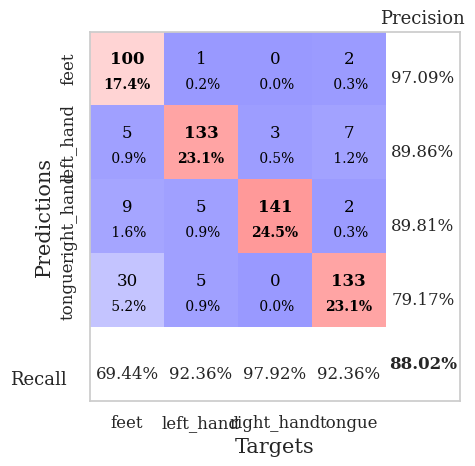

In [10]:
from sklearn.metrics import confusion_matrix

from braindecode.visualization import plot_confusion_matrix

# generate confusion matrices
# get the targets
y_true = valid_set.get_metadata().target
y_pred = clf.predict(valid_set)

# generating confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# add class labels
# label_dict is class_name : str -> i_class : int
label_dict = valid_set.datasets[0].window_kwargs[0][1]['mapping']
# sort the labels by values (values are integer class labels)
labels = [k for k, v in sorted(label_dict.items(), key=lambda kv: kv[1])]

# plot the basic conf. matrix
plot_confusion_matrix(confusion_mat, class_names=labels)

## References

.. [1] Tangermann, M., Müller, K.R., Aertsen, A., Birbaumer, N., Braun, C.,
       Brunner, C., Leeb, R., Mehring, C., Miller, K.J., Mueller-Putz, G.
       and Nolte, G., 2012. Review of the BCI competition IV.
       Frontiers in neuroscience, 6, p.55.

.. [2] Schirrmeister, R.T., Springenberg, J.T., Fiederer, L.D.J., Glasstetter, M.,
       Eggensperger, K., Tangermann, M., Hutter, F., Burgard, W. and Ball, T. (2017),
       Deep learning with convolutional neural networks for EEG decoding and visualization.
       Hum. Brain Mapping, 38: 5391-5420. https://doi.org/10.1002/hbm.23730.

